# Data Understanding - Server Logs
### 1. Nguồn dữ liệu
### 2. Mô tả trường thông tin
#### Dữ liệu log có cấu trúc gồm các trường chính:
| **Tên Trường**        | **Kiểu Dữ Liệu**       | **Mô Tả Ý Nghĩa**                                                      |
|-----------------------|------------------------|-------------------------------------------------------------------------|
| `std`                 | String                 | Loại log: `stdout` (log bình thường) hoặc `stderr` (log lỗi).                |
| `remote_address`      | String                 | Địa chỉ IP của máy khách.                                      |
| `remote_user`         | String                 | Tên người dùng (dấu `-` nếu không có thông tin).     |
| `datetime`            | Datetime               | Thời gian và ngày giờ của request, định dạng theo chuẩn ISO8601: `yyyy-MM-dd'T'HH:mm:ss.SSSSSSSSS+hh:mm`|
| `method`              | String                 | Phương thức HTTP (ví dụ: GET, POST, PUT, DELETE,...)                 |
| `path`                | String                 | Đường dẫnđược truy cập trên máy chủ (ví dụ: `/status`, `/api/data`)           |
| `header`              | String                 | Phiên bản giao thức HTTP (ví dụ: `HTTP/1.1`).                           |
| `status`              | Integer                | Mã trạng thái HTTP trả về (ví dụ: `200`, `404`, `500`)                |
| `bytes_sent`          | Integer                | Số byte dữ liệu đã được gửi trong phản hồi (response)                |
| `referer`             | String                 | URL nguồn (referer) của request           |
| `user_agent`          | String                 | Thông tin về trình duyệt hoặc công cụ gửi request. |
### 3. Tách các dòng log thành các trường dữ liệu
#### Ví dụ ta có dữ liệu như sau:<br>2024-11-30T13:51:41.272335253+07:00 stdout F 127.0.0.1 - - [30/Nov/2024:06:51:41 +0000] "GET /status HTTP/1.1" 200 1164 "-" "kong-ingress-controller/3.3.1"<br>2024-11-30T13:51:42.210291667+07:00 stderr F 10.244.3.1 - - [30/Nov/2024:06:51:42 +0000] "GET /status HTTP/1.1" 200 1165 "-" "kube-probe/1.27"<br>2024-11-30T13:51:42.213094133+07:00 stderr F 10.244.3.1 - - [30/Nov/2024:06:51:42 +0000] "GET /status/ready HTTP/1.1" 200 19 "-" "kube-probe/1.27"

#### Mục tiêu là tách các trường dữ liệu và đưa về dạng:<br>
| std    | remote_address | remote_user | datetime                    | method | path          | header   | status | bytes_sent | referer | user_agent                     |
|--------|----------------|-------------|-----------------------------|--------|---------------|----------|--------|------------|---------|--------------------------------|
| stdout | 127.0.0.1      | -           | 30/Nov/2024:06:51:41 +0000 | GET    | /status       | HTTP/1.1 | 200    | 1164       | -       | kong-ingress-controller/3.3.1 |
| stderr | 10.244.3.1     | -           | 30/Nov/2024:06:51:42 +0000 | GET    | /status       | HTTP/1.1 | 200    | 1165       | -       | kube-probe/1.27               |
| stderr | 10.244.3.1     | -           | 30/Nov/2024:06:51:42 +0000 | GET    | /status/ready | HTTP/1.1 | 200    | 19         | -       | kube-probe/1.27               |
#### Để đạt được các trường dữ liệu đó, ta cần thiết kế biểu thức regex tương ứng: <br> 
```regex
^
\S+                              # Phần đầu dòng, bỏ qua chuỗi không chứa khoảng trắng.
 (?P<std>\S+)                    # Nhóm `std`: stdout/stderr.
 \S+                             # Bỏ qua một chuỗi không chứa khoảng trắng.
 (?P<remote_address>\d+\.\d+\.\d+\.\d+) # Nhóm `remote_address`: Địa chỉ IP (IPv4).
 -                               # Ký tự gạch ngang.
 (?P<remote_user>[^ ]*)          # Nhóm `remote_user`: Tên người dùng (hoặc trống: `-`).
 \[(?P<datetime>[^\]]+)\]        # Nhóm `datetime`: Thời gian (nằm trong dấu `[]`).
 "(?P<method>\w+)                # Nhóm `method`: Phương thức HTTP (GET, POST,...).
  (?P<path>[^\s]+)               # Nhóm `path`: Đường dẫn truy cập.
  (?P<header>[^\"]+)"            # Nhóm `header`: Phiên bản giao thức (HTTP/1.1).
 (?P<status>\d+)                 # Nhóm `status`: Mã trạng thái HTTP (200, 404,...).
 (?P<bytes_sent>\d+)             # Nhóm `bytes_sent`: Số byte đã gửi.
 "(?P<referer>[^\"]*)"           # Nhóm `referer`: URL nguồn (có thể trống: `-`).
 "(?P<user_agent>[^\"]*)"        # Nhóm `user_agent`: Thông tin User-Agent.

In [2]:
import pandas as pd
import numpy as np
import os
import re
from tqdm import tqdm

In [3]:
file_log= r'D:\CODING\Project\Server Log Analysis\data\raw\server_log.txt'

In [4]:
log_pattern= r'^\S+ (?P<std>\S+) \S+ (?P<remote_address>\d+\.\d+\.\d+\.\d+) - (?P<remote_user>[^ ]*) \[(?P<datetime>[^\]]+)\] "(?P<method>\w+) (?P<path>[^\s]+) (?P<header>[^\"]+)" (?P<status>\d+) (?P<bytes_sent>\d+) "(?P<referer>[^\"]*)" "(?P<user_agent>[^\"]*)"'

In [5]:
with open(file_log, 'r') as file:
    log_lines = file.readlines()

In [6]:
parsed_logs = [re.match(log_pattern, line).groupdict() for line in log_lines if re.match(log_pattern, line)]

In [7]:
df = pd.DataFrame(parsed_logs)

In [8]:
df.head()

,std,remote_address,remote_user,datetime,method,path,header,status,bytes_sent,referer,user_agent
0,stdout,127.0.0.1,-,30/Nov/2024:06:51:41 +0000,GET,/status,HTTP/1.1,200,1164,-,kong-ingress-controller/3.3.1
1,stderr,10.244.3.1,-,30/Nov/2024:06:51:42 +0000,GET,/status,HTTP/1.1,200,1165,-,kube-probe/1.27
2,stderr,10.244.3.1,-,30/Nov/2024:06:51:42 +0000,GET,/status/ready,HTTP/1.1,200,19,-,kube-probe/1.27
3,stdout,127.0.0.1,-,30/Nov/2024:06:51:44 +0000,GET,/status,HTTP/1.1,200,1164,-,kong-ingress-controller/3.3.1
4,stdout,127.0.0.1,-,30/Nov/2024:06:51:47 +0000,GET,/status,HTTP/1.1,200,1164,-,kong-ingress-controller/3.3.1


In [9]:
df.to_csv(r'D:\CODING\Project\Server Log Analysis\data\interim\parsed_logs.csv')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66411 entries, 0 to 66410
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   std             66411 non-null  object
 1   remote_address  66411 non-null  object
 2   remote_user     66411 non-null  object
 3   datetime        66411 non-null  object
 4   method          66411 non-null  object
 5   path            66411 non-null  object
 6   header          66411 non-null  object
 7   status          66411 non-null  object
 8   bytes_sent      66411 non-null  object
 9   referer         66411 non-null  object
 10  user_agent      66411 non-null  object
dtypes: object(11)
memory usage: 5.6+ MB


Data Preprocessing

In [11]:
df['std'] = df['std'].replace({'stdout': 0, 'stderr': 1})

C:\Users\Admin\AppData\Local\Temp\ipykernel_22200\2296486338.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['std'] = df['std'].replace({'stdout': 0, 'stderr': 1})


In [12]:
from datetime import datetime
df['datetime'] = df['datetime'].apply(lambda x: datetime.strptime(x, "%d/%b/%Y:%H:%M:%S %z"))

In [13]:
df = df.drop(['remote_user'], axis = 1)

In [14]:
df['method'] = df['method'].replace({'GET': 0, 'POST': 1})

C:\Users\Admin\AppData\Local\Temp\ipykernel_22200\1831852460.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['method'] = df['method'].replace({'GET': 0, 'POST': 1})


In [15]:
df = df.drop(['header'], axis = 1)

In [16]:
df ['bytes_sent'] = pd.to_numeric(df['bytes_sent'])

In [17]:
df['status'] = pd.to_numeric(df['status'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66411 entries, 0 to 66410
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   std             66411 non-null  int64              
 1   remote_address  66411 non-null  object             
 2   datetime        66411 non-null  datetime64[ns, UTC]
 3   method          66411 non-null  int64              
 4   path            66411 non-null  object             
 5   status          66411 non-null  int64              
 6   bytes_sent      66411 non-null  int64              
 7   referer         66411 non-null  object             
 8   user_agent      66411 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(4), object(4)
memory usage: 4.6+ MB


In [18]:
df.isnull().sum()

std               0
remote_address    0
datetime          0
method            0
path              0
status            0
bytes_sent        0
referer           0
user_agent        0
dtype: int64

In [19]:
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month

### 4. Minh họa dữ liệu

request_type     Hợp lệ  Lỗi
hour date                   
0    2024-12-01    2041   16
1    2024-12-01    2043   20
2    2024-12-01    1931   18
3    2024-12-01    1987   28
4    2024-12-01    2143   20
5    2024-12-01    2168   16
6    2024-11-30     300    2
     2024-12-01    2057   27
7    2024-11-30    2226   35
     2024-12-01    2179   20
8    2024-11-30    2291   55
     2024-12-01    2116   21
9    2024-11-30    2131   33
     2024-12-01    2162   20
10   2024-11-30    2172   47
     2024-12-01    2147   23
11   2024-11-30    2077   27
     2024-12-01    1980   18
12   2024-11-30    1999   24
     2024-12-01    2039   24
13   2024-11-30    2123   22
     2024-12-01    2064   23
14   2024-11-30    1981   20
     2024-12-01     672    9
15   2024-11-30    2051   16
16   2024-11-30    2156   24
17   2024-11-30    2153   25
18   2024-11-30    2048   24
19   2024-11-30    2050   16
20   2024-11-30    2279   15
21   2024-11-30    1923   24
22   2024-11-30    2042   17
23   2024-11-3

<Figure size 1000x600 with 0 Axes>

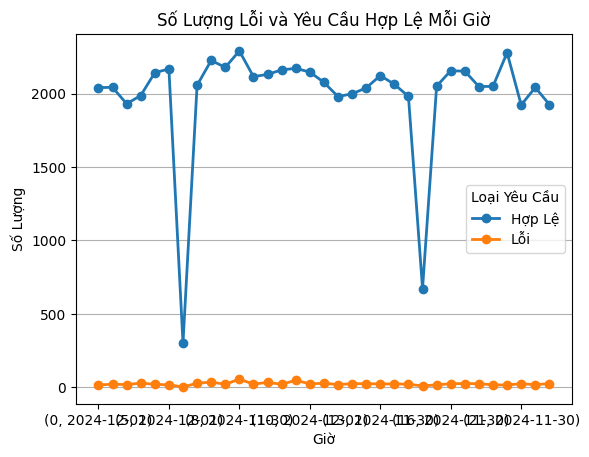

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Dữ liệu log mẫu


# Đọc dữ liệu vào DataFrame
log_df = pd.read_csv(r'D:\CODING\Project\Server Log Analysis\data\interim\parsed_logs.csv')

# Chuyển đổi cột datetime về kiểu dữ liệu datetime
log_df['datetime'] = pd.to_datetime(log_df['datetime'], format='%d/%b/%Y:%H:%M:%S +0000')

# Thêm cột "hour" để phân nhóm theo giờ
log_df['hour'] = log_df['datetime'].dt.hour

# Phân loại trạng thái HTTP thành "Lỗi" và "Hợp lệ"
log_df['request_type'] = log_df['status'].apply(lambda x: 'Lỗi' if x >= 400 else 'Hợp lệ')

# Đếm số lượng lỗi và hợp lệ mỗi giờ
hourly_counts = log_df.groupby(['hour', 'request_type']).size().unstack(fill_value=0)
print(hourly_counts)
# Vẽ biểu đồ với seaborn
plt.figure(figsize=(10, 6))
hourly_counts.plot(kind='line', marker='o', linewidth=2)

# Tùy chỉnh biểu đồ
plt.title("Số Lượng Lỗi và Yêu Cầu Hợp Lệ Mỗi Giờ")
plt.xlabel("Giờ")
plt.ylabel("Số Lượng")
plt.xticks(rotation=0)
plt.legend(title="Loại Yêu Cầu", labels=["Hợp Lệ", "Lỗi" ])
plt.grid(True, axis='y')

# Hiển thị biểu đồ
plt.show()

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt

# Tính số lượng các loại yêu cầu
request_counts = log_df['request_type'].value_counts()

# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 8))
request_counts.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'], startangle=90, legend=False)

# Tùy chỉnh biểu đồ
plt.title("Tỷ Lệ Phân Bố Các Loại Yêu Cầu")
plt.ylabel("")  # Xóa nhãn y-axis
plt.show()


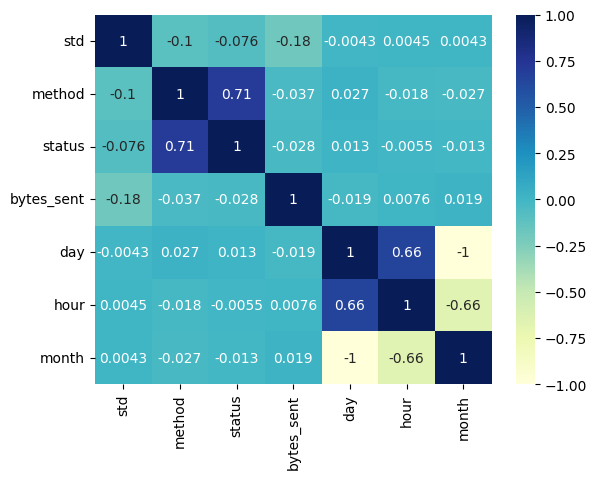

In [21]:
dataplot = sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)
plt.show()

In [22]:
df.head(3)

,std,remote_address,datetime,method,path,status,bytes_sent,referer,user_agent,day,hour,month
0,0,127.0.0.1,2024-11-30 06:51:41+00:00,0,/status,200,1164,-,kong-ingress-controller/3.3.1,30,6,11
1,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status,200,1165,-,kube-probe/1.27,30,6,11
2,1,10.244.3.1,2024-11-30 06:51:42+00:00,0,/status/ready,200,19,-,kube-probe/1.27,30,6,11
